In [1]:
# !pip install --upgrade openpyxl


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os
import textwrap
from prettytable import PrettyTable
# adding entry into the specifications
# of the warnings filter.
warnings.filterwarnings('ignore', '.*do not.*', )
# import pandas as pd
# warnings.simplefilter(action='ignore', category=pd.SettingWithCopyWarning)


C:\Users\ishim\AppData\Roaming\Python\Python39\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
C:\Users\ishim\AppData\Roaming\Python\Python39\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.4' currently installed).
  from pandas.core import (
c:\ProgramData\Anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
data = pd.read_excel("adherence_dataset.xlsx")

### important functions

In [4]:
def plot_hospital_data(df, columns, title):
    fig, axes = plt.subplots(2, 5, figsize=(20, 10))

    # Flatten the axes array for easy indexing
    axes = axes.flatten()

    # Define custom colors
    colors = {'Completed': 'blue', 'Partially Completed': 'green', 'Not Completed': 'orange'}

    # List of unique hospitals
    hospitals = df['hospital'].unique()

    # Loop through each hospital and plot a stacked bar graph
    for idx, hospital in enumerate(hospitals):
        if idx >= len(axes):  # Avoid index error if hospitals > subplot count
            break

        # Filter data for the specific hospital
        hospital_data = df[df['hospital'] == hospital]
        
        # Count the occurrences of each category in the given columns
        category_counts = hospital_data[columns].apply(pd.Series.value_counts).T.fillna(0)
        
        # Plot stacked bar graph with predefined colors
        category_counts.plot(kind='bar', stacked=True, ax=axes[idx], 
                             color=[colors.get(col, 'gray') for col in category_counts.columns])
        
        axes[idx].set_title(hospital)
        # axes[idx].set_xlabel('Categories')
        axes[idx].set_ylabel('Count')
        axes[idx].tick_params(axis='x', rotation=45)  # Set x-axis ticks rotation
        axes[idx].get_legend().remove()  # Remove legend from individual subplots

    # Add a common title
    fig.suptitle(title, fontsize=16, fontweight='bold')

    # Create a common legend with the specified colors
    handles = [plt.Rectangle((0,0),1,1, color=color) for color in colors.values()]
    labels = list(colors.keys())

    fig.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.5, -0.05), ncol=3)

    # Adjust the layout
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust layout to accommodate title and legend
    plt.show()

# Example usage:





def replace_values_in_columns(df, columns):
    """
    Replaces values in specified columns of a DataFrame:
    - Replace 1 with 0
    - Replace 2 with 50
    - Replace 3 with 100

    Parameters:
        df (pd.DataFrame): The input DataFrame.
        columns (list): List of column names to apply the replacements.

    Returns:
        pd.DataFrame: The updated DataFrame with replaced values.
    """
    # Define the mapping dictionary
    value_mapping = {
        3: 0,
        2: 50,
        1: 100
    }

    # Apply the mapping to the specified columns
    for col in columns:
        if col in df.columns:
            df[col] = df[col].map(value_mapping)
        else:
            print(f"Warning: Column '{col}' does not exist in the DataFrame.")

    return df



def add_average_column(df, columns, new_column_name):
    """
    Adds a new column to the DataFrame containing the average of the specified columns.

    Parameters:
        df (pd.DataFrame): The input DataFrame.
        columns (list): List of column names to calculate the average from.
        new_column_name (str): Name of the new column to store the averages.

    Returns:
        pd.DataFrame: The DataFrame with the new column added.
    """
    # Calculate the average and add as a new column
    df[new_column_name] = df[columns].mean(axis=1)
    return df

def refined_stoplight_chart(df, hospital_name_col, hospital_level_col, category_cols, save_path=None):
    """
    Creates a refined stoplight chart with hospital names in the first row, levels in the second row,
    and category rows below. The left vertical line of the first column is removed.

    Parameters:
        df (pd.DataFrame): DataFrame containing the data.
        hospital_name_col (str): Column for hospital names.
        hospital_level_col (str): Column for hospital levels.
        category_cols (list): List of category columns.
        save_path (str): Optional path to save the chart.

    Returns:
        None: Displays or saves the chart.
    """
    def get_color(value):
        """Return circle color based on percentage thresholds."""
        if value > 95:
            return 'green'
        elif 75 <= value <= 95:
            return 'yellow'
        else:
            return 'red'

    def wrap_text(text, width):
        """Wrap text to a specified width."""
        return "\n".join(textwrap.wrap(text, width))

    # Figure setup
    n_hospitals = len(df)
    n_categories = len(category_cols)
    cell_height = 1.5
    cell_width = 2.5
    fig_width = cell_width * (n_hospitals + 1)
    fig_height = cell_height * (n_categories + 2)  # +2 for hospital name and level rows
    fig, ax = plt.subplots(figsize=(fig_width, fig_height))
    ax.axis('off')

    # Draw grid (horizontal lines)
    for row in range(n_categories + 3):  # +3 for header rows and empty space
        ax.plot([0, fig_width], [row * cell_height, row * cell_height], color='black', linewidth=0.5)

    # Draw vertical grid lines except for the first column
    for col in range(1, n_hospitals + 2):  # +2 for labels and header
        ax.plot([col * cell_width, col * cell_width], [0, fig_height], color='black', linewidth=0.5)

    # Hospital names (First Row)
    for col_idx, hospital_name in enumerate(df[hospital_name_col]):
        x_pos = (col_idx + 1) * cell_width + cell_width / 2
        y_pos = fig_height - cell_height / 2
        wrapped_name = wrap_text(hospital_name, 12)  # Wrap hospital names to a width of 12 characters
        ax.text(x_pos, y_pos, wrapped_name, ha='center', va='center', fontsize=15, weight='bold')

    # Hospital levels (Second Row)
    for col_idx, hospital_level in enumerate(df[hospital_level_col]):
        x_pos = (col_idx + 1) * cell_width + cell_width / 2
        y_pos = fig_height - cell_height * 1.5
        wrapped_level = wrap_text(hospital_level, 12)  # Wrap hospital levels if necessary
        ax.text(x_pos, y_pos, wrapped_level, ha='center', va='center', fontsize=12, weight='bold', color='black')

    # Category labels (First Column, no vertical line)
    for row_idx, category in enumerate(category_cols):
        y_pos = fig_height - (row_idx + 3) * cell_height + cell_height / 2
        wrapped_category = wrap_text(category, 20)  # Wrap categories to a width of 20 characters
        ax.text(cell_width / 2, y_pos, wrapped_category, ha='right', va='center', fontsize=12)

    # Circles for data
    for row_idx, category in enumerate(category_cols):
        for col_idx in range(n_hospitals):
            value = df.iloc[col_idx][category]
            color = get_color(value)
            x_pos = (col_idx + 1) * cell_width + cell_width / 2
            y_pos = fig_height - (row_idx + 3) * cell_height + cell_height / 2
            ax.add_patch(plt.Circle((x_pos, y_pos), 0.4, color=color))

    # Adjust the left column (remove vertical line)
    ax.plot([0, cell_width], [0, fig_height], color='white', linewidth=2)

    # Save or display chart
    if save_path:
        plt.savefig(save_path, bbox_inches='tight', dpi=300)
    plt.show()

### Section 1: Triage

In [5]:
hospital_mapping = {
    1: "CHUK",
    2: "Masaka DH",
    3: "Nyamata DH",
    4: "Kirehe DH",
    5: "Butaro DH",
    6: "Nemba DH",
    7: "CHUB",
    8: "Kabutare DH",
    9: "Kibogora DH",
    10: "Gisenyi DH"
}
data["hospital"] = data["hospital"].map(hospital_mapping)


In [6]:

hospital_levels = {
    "CHUK": "Referral/Teaching Hospital",
    "Masaka DH": "District Hospital",
    "Nyamata DH": "Level 2 Teaching Hospital",
    "Kirehe DH": "District Hospital",
    "Butaro DH": "Level 2 Teaching Hospital",
    "Nemba DH": "District Hospital",
    "CHUB": "Referral/Teaching Hospital",
    "Kabutare DH": "District Hospital",
    "Kibogora DH": "Level 2 Teaching Hospital",
    "Gisenyi DH": "District Hospital"
}

# Add the new column based on the mapping
data['hospital_level'] = data['hospital'].map(hospital_levels)

In [7]:
patient_detail = ['patient_names1', 'age_dob1', 'sex1']
triage = ['appropriate_triage_form_us', 'arrival_date', 'arrival_time', 'chief_complaint', 'patient_weight_indicated',
       'patient_weight_and_height', 'respiratory_rate_document', 'heart_rate_recorded', 'temp', 'oxygen_saturation', 'glycemia',
       'pain_assessment', 'triage_nurse_start_time', 'triage_nurse_end_time', 'nurses_name_legible', 'nurses_signature', 'in_case_of_urgent_case', 'name_of_physician_attend', 'time_doctor_attended']
emergency_signs = ['airway_breathing_state', 'circulation_status_ticked', 'convulsions_if_any_indicate', 'coma_state_indicated', 'trauma_where_applicable', 'other_signs_symptoms']
vital_signs = ['heart_rate_vital_signs', 'temperature_recorded', 'respiratory_rate_recorded', 'oxygen_saturation_recorded', 'pain_assessed_and_document', 'glycaemia_assessed',]

In [8]:
# data = replace_values_in_columns(df = data, columns = patient_detail)
# data = replace_values_in_columns(df = data, columns = triage)
# data = replace_values_in_columns(df = data, columns = emergency_signs)
# data = replace_values_in_columns(df = data, columns = vital_signs)

In [9]:
# data = add_average_column(df= data, columns = patient_detail, new_column_name = 'Patient details')
# data = add_average_column(df= data, columns = triage, new_column_name = 'Triage')
# data = add_average_column(df= data, columns = emergency_signs, new_column_name = 'Emergency Signs')
# data = add_average_column(df= data, columns = vital_signs, new_column_name = 'Vital Signs')

In [10]:
# def group_hospital_avg(df: pd.DataFrame, hospital_col: str, continuous_cols: list) -> pd.DataFrame:
#     """
#     Groups the DataFrame by hospital name and calculates the average for each continuous column.
    
#     Parameters:
#         df (pd.DataFrame): The input DataFrame.
#         hospital_col (str): The column name containing hospital names (categorical variable).
#         continuous_cols (list): A list of column names with continuous values.
    
#     Returns:
#         pd.DataFrame: A new DataFrame with hospital names and average values for each continuous column.
#     """
#     return df.groupby(hospital_col)[continuous_cols].mean().reset_index()

In [11]:
# triage_data = group_hospital_avg(data, 'hospital', ['Patient details','Triage','Emergency Signs','Vital Signs'])
# triage_data['hospital_level'] = triage_data["hospital"].map(hospital_levels)

In [12]:
# refined_stoplight_chart(
#     df=triage_data,
#     hospital_name_col="hospital",
#     hospital_level_col="hospital_level",
#     category_cols=['Patient details','Triage','Emergency Signs','Vital Signs']
# )

In [13]:
import pandas as pd

def replace_status(df, columns):
    """
    Replace values in the specified columns with corresponding status labels.
    
    Args:
    df (pd.DataFrame): The input DataFrame.
    columns (list): List of column names where replacements should be applied.
    
    Returns:
    pd.DataFrame: DataFrame with replaced values.
    """
    # Define the mapping
    mapping = {1: "Completed", 2: "Partially Completed", 3: "Not Completed"}
    
    # Replace values in the specified columns
    df[columns] = df[columns].replace(mapping)
    
    return df

data = replace_status(data, ['patient_names1', 'age_dob1', 'sex1','airway_breathing_state', 'circulation_status_ticked', 'convulsions_if_any_indicate', 'coma_state_indicated', 'trauma_where_applicable', 'other_signs_symptoms','heart_rate_vital_signs', 'temperature_recorded', 'respiratory_rate_recorded', 'oxygen_saturation_recorded', 'pain_assessed_and_document', 'glycaemia_assessed', 'appropriate_triage_form_us', 'arrival_date', 'arrival_time', 'chief_complaint', 'patient_weight_indicated',
       'patient_weight_and_height', 'respiratory_rate_document', 'heart_rate_recorded', 'temp', 'oxygen_saturation', 'glycemia',
       'pain_assessment', 'triage_nurse_start_time', 'triage_nurse_end_time', 'nurses_name_legible', 'nurses_signature', 'in_case_of_urgent_case', 'name_of_physician_attend', 'time_doctor_attended'])
# emergency_signs = ['airway_breathing_state', 'circulation_status_ticked', 'convulsions_if_any_indicate', 'coma_state_indicated', 'trauma_where_applicable', 'other_signs_symptoms'])
print(data[['hospital','patient_names1', 'age_dob1', 'sex1']])


       hospital       patient_names1             age_dob1           sex1
0    Nyamata DH            Completed            Completed      Completed
1    Nyamata DH            Completed            Completed      Completed
2      Nemba DH            Completed            Completed      Completed
3      Nemba DH        Not Completed        Not Completed  Not Completed
4    Nyamata DH            Completed            Completed      Completed
5    Nyamata DH            Completed            Completed      Completed
6    Nyamata DH            Completed            Completed      Completed
7      Nemba DH            Completed            Completed      Completed
8      Nemba DH            Completed            Completed      Completed
9     Masaka DH            Completed            Completed      Completed
10    Masaka DH            Completed            Completed      Completed
11    Masaka DH            Completed            Completed      Completed
12    Masaka DH            Completed            Com

In [14]:
data[['Patient Names', 'Age and DOB', 'Sex']] = data[['patient_names1', 'age_dob1', 'sex1']]
data[['Airway breathing state', 'Circulation status ticked', 'Convulsions if any indicate', 'Coma state indicated', 'Trauma where applicable', 'Other signs symptoms']] = data[['airway_breathing_state', 'circulation_status_ticked', 'convulsions_if_any_indicate', 'coma_state_indicated', 'trauma_where_applicable', 'other_signs_symptoms']]
data[['Heart rate vital signs', 'Temperature recorded', 'Respiratory rate recorded', 'Oxygen saturation recorded', 'Pain assessed and document', 'Glycaemia_assessed']] = data[['heart_rate_vital_signs', 'temperature_recorded', 'respiratory_rate_recorded', 'oxygen_saturation_recorded', 'pain_assessed_and_document', 'glycaemia_assessed']]

data[['Appropriate triage form', 'Arrival date', 'Arrivaltime', 'chief complaint', 'Patient weight indicated',
       'Patient weight and height', 'Respiratory rate document', 'Heart rate recorded', 'temp', 'Oxygen saturation', 'Glycemia',
       'Pain assessment', 'Triage nurse start time', 'Triage nurse end time', 'Nurses name legible', 'Nurses signature', 'In case of urgent case', 'Name of physician attend', 'Time doctor attended']] = data[['appropriate_triage_form_us', 'arrival_date', 'arrival_time', 'chief_complaint', 'patient_weight_indicated',
       'patient_weight_and_height', 'respiratory_rate_document', 'heart_rate_recorded', 'temp', 'oxygen_saturation', 'glycemia',
       'pain_assessment', 'triage_nurse_start_time', 'triage_nurse_end_time', 'nurses_name_legible', 'nurses_signature', 'in_case_of_urgent_case', 'name_of_physician_attend', 'time_doctor_attended']]


In [15]:
data[['Patient Names', 'Age and DOB', 'Sex']]

,Patient Names,Age and DOB,Sex
0,Completed,Completed,Completed
1,Completed,Completed,Completed
2,Completed,Completed,Completed
3,Not Completed,Not Completed,Not Completed
4,Completed,Completed,Completed
5,Completed,Completed,Completed
6,Completed,Completed,Completed
7,Completed,Completed,Completed
8,Completed,Completed,Completed
9,Completed,Completed,Completed


In [16]:
# 34fds1

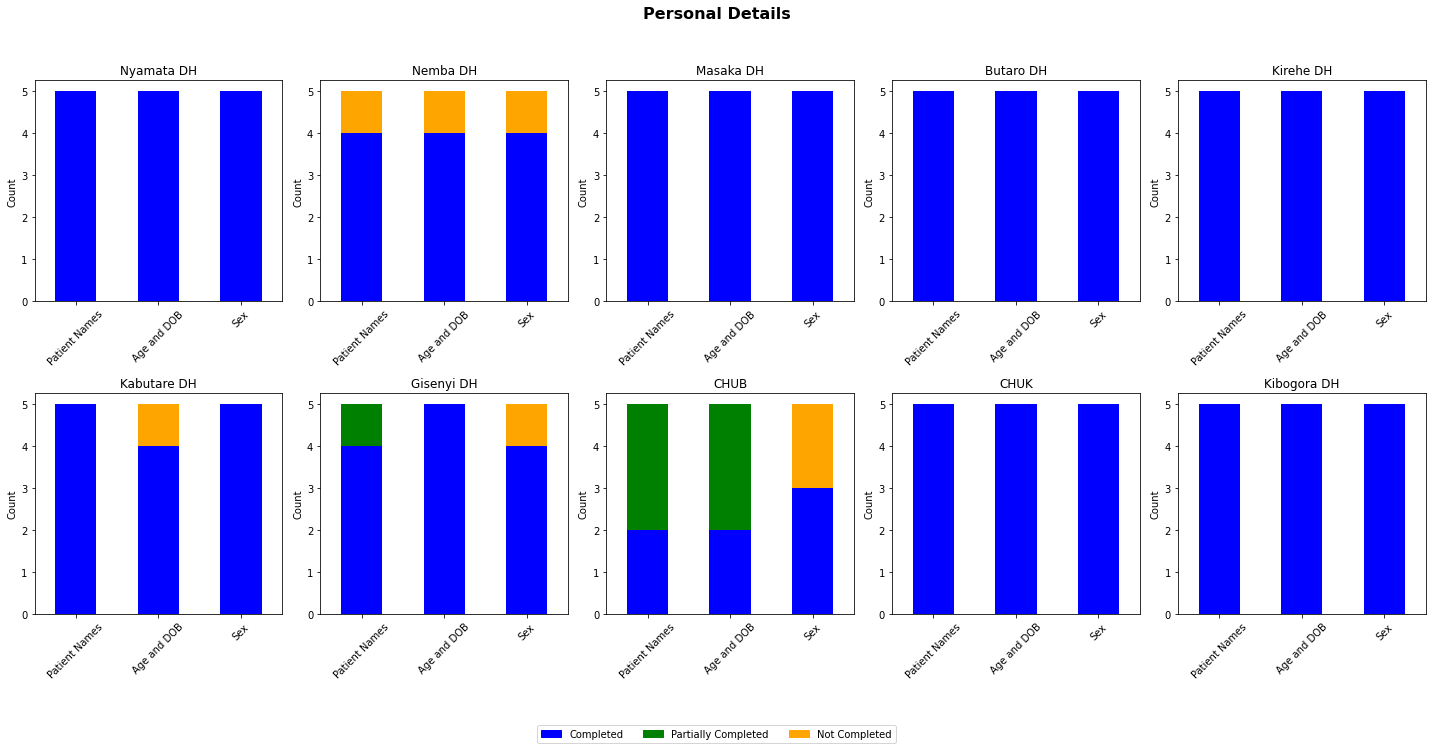

In [17]:
import matplotlib.pyplot as plt
import pandas as pd

fig, axes = plt.subplots(2, 5, figsize=(20, 10))

# Flatten the axes array for easy indexing
axes = axes.flatten()

# Define custom colors
colors = {'Completed': 'blue', 'Partially Completed': 'green', 'Not Completed': 'orange'}

# List of unique hospitals
hospitals = data['hospital'].unique()

# Loop through each hospital and plot a stacked bar graph
for idx, hospital in enumerate(hospitals):
    # Filter data for the specific hospital
    hospital_data = data[data['hospital'] == hospital]
    
    # Count the occurrences of each category in 'patient_names1', 'age_dob1', 'sex1'
    category_counts = hospital_data[['Patient Names', 'Age and DOB', 'Sex']].apply(pd.Series.value_counts).T.fillna(0)
    
    # Plot stacked bar graph with predefined colors
    category_counts.plot(kind='bar', stacked=True, ax=axes[idx], color=[colors.get(col, 'gray') for col in category_counts.columns])
    
    axes[idx].set_title(hospital)
    # axes[idx].set_xlabel('Categories')
    axes[idx].set_ylabel('Count')
    axes[idx].tick_params(axis='x', rotation=45)  # Set x-axis ticks rotation
    axes[idx].get_legend().remove()  # Remove legend from individual subplots

# Add a common title
fig.suptitle("Personal Details", fontsize=16, fontweight='bold')

# Create a common legend with the specified colors
handles = [plt.Rectangle((0,0),1,1, color=color) for color in colors.values()]
labels = list(colors.keys())

fig.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.5, -0.05), ncol=3)

# Adjust the layout
plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust layout to accommodate title and legend
plt.show()


In [18]:
import matplotlib.pyplot as plt
import pandas as pd

def plot_hospital_data2(df, columns, title):
    fig, axes = plt.subplots(2, 5, figsize=(20, 10), sharex=True)  # 2 rows, 5 columns

    # Flatten the axes array for easy iteration
    axes = axes.flatten()

    # Define custom colors
    colors = {'Completed': 'blue', 'Partially Completed': 'green', 'Not Completed': 'orange'}

    # List of unique hospitals
    hospitals = df['hospital'].unique()

    # Get all possible categories across all hospitals
    all_categories = set()
    for col in columns:
        all_categories.update(df[col].unique())
    
    all_categories = sorted(all_categories)  # Sort for consistent order

    # Loop through each hospital and plot a stacked bar graph
    for idx, hospital in enumerate(hospitals):
        if idx >= len(axes):  # Avoid index error if hospitals > subplot count
            break

        # Filter data for the specific hospital
        hospital_data = df[df['hospital'] == hospital]
        
        # Count occurrences of each category in the given columns
        category_counts = hospital_data[columns].apply(pd.Series.value_counts).T.fillna(0)

        # Ensure missing categories have zero counts
        category_counts = category_counts.reindex(columns=all_categories, fill_value=0)

        # Plot stacked bar graph with predefined colors
        category_counts.plot(kind='bar', stacked=True, ax=axes[idx], 
                             color=[colors.get(col, 'gray') for col in category_counts.columns])
        
        axes[idx].set_title(hospital)
        axes[idx].get_legend().remove()  # Remove legend from individual subplots

        # Hide x-axis labels for all but the last row
        if idx < len(axes) - 5:  # Hide for first row (since 2 rows in grid)
            axes[idx].set_xticklabels([])
        else:
            axes[idx].tick_params(axis='x', labelrotation=90)  # Rotate labels for last row

    # Add a common title
    fig.suptitle(title, fontsize=16, fontweight='bold')

    # Create a common legend with the specified colors
    handles = [plt.Rectangle((0,0),1,1, color=color) for color in colors.values()]
    labels = list(colors.keys())

    fig.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.5, -0.05), ncol=3)

    # Adjust the layout
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust layout to accommodate title and legend
    plt.show()


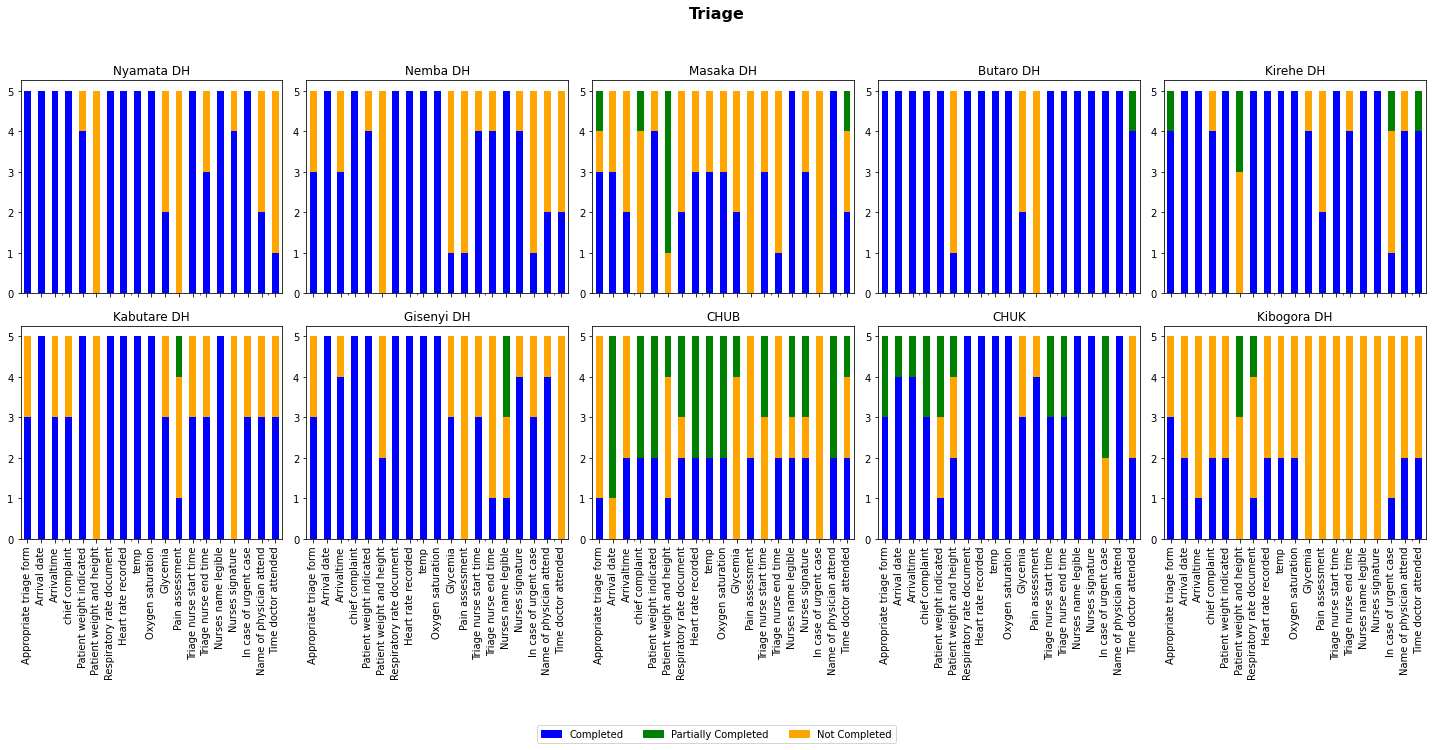

In [19]:
plot_hospital_data2(data, ['Appropriate triage form', 'Arrival date', 'Arrivaltime', 'chief complaint', 'Patient weight indicated',
       'Patient weight and height', 'Respiratory rate document', 'Heart rate recorded', 'temp', 'Oxygen saturation', 'Glycemia',
       'Pain assessment', 'Triage nurse start time', 'Triage nurse end time', 'Nurses name legible', 'Nurses signature', 'In case of urgent case', 'Name of physician attend', 'Time doctor attended'], "Triage")

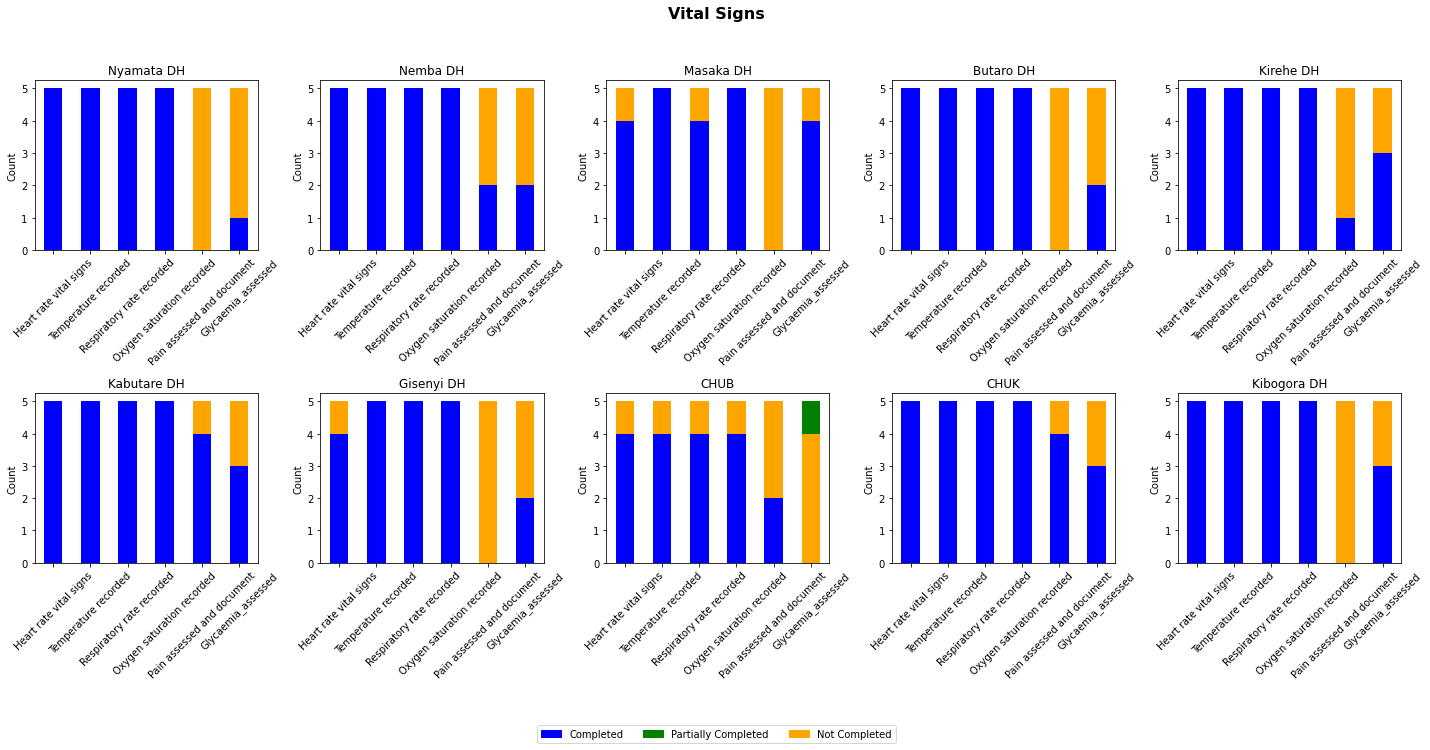

In [20]:
plot_hospital_data(data, ['Heart rate vital signs', 'Temperature recorded', 'Respiratory rate recorded', 'Oxygen saturation recorded', 'Pain assessed and document', 'Glycaemia_assessed'], "Vital Signs")

In [21]:
# import pandas as pd


# def generate_frequency_table(df: pd.DataFrame, columns: list, export_excel: bool = False, filename: str = "vital_frequency_table.xlsx"):
#     excel_data = {}
    
#     for col in columns:
#         if col not in df.columns:
#             print(f"Column '{col}' not found in DataFrame.")
#             continue
        
#         value_counts = df[col].value_counts(dropna=False)
#         total_count = len(df)
        
#         table = PrettyTable([col, "Count", "Percentage (%)"])
#         data = []
        
#         for value, count in value_counts.items():
#             percentage = (count / total_count) * 100
#             table.add_row([value, count, f"{percentage:.2f}"])
#             data.append([value, count, percentage])
        
#         print(f"\nFrequency Table for '{col}':")
#         print(table)
        
#         excel_data[col] = pd.DataFrame(data, columns=[col, "Count", "Percentage (%)"])
    
#     if export_excel and excel_data:
#         with pd.ExcelWriter(filename) as writer:
#             for col, df_data in excel_data.items():
#                 df_data.to_excel(writer, sheet_name=col, index=False)
#         print(f"Frequency tables exported to {filename}")


In [22]:
# generate_frequency_table(data, ['heart_rate_vital_signs', 'temperature_recorded', 'respiratory_rate_recorded', 'oxygen_saturation_recorded', 'pain_assessed_and_document', 'glycaemia_assessed'], export_excel=True)


### TRIAGE WAITING TIME AUDIT 

In [23]:
def convert_mixed_datetime(value):
    try:
        # Try parsing full datetime format
        return pd.to_datetime(value)
    except:
        # If only time is present, prepend the reference date
        return pd.to_datetime(f"{reference_date} {value}")
    
def clean_column_values(df, column_name):
    """
    Replaces values in the specified column of a dataframe:
    - Values < 0 or > 100 are replaced with 0.
    
    Parameters:
    df (pd.DataFrame): The dataframe to modify.
    column_name (str): The name of the column to clean.
    
    Returns:
    pd.DataFrame: The modified dataframe.
    """
    df.loc[(df[column_name] < 0) | (df[column_name] > 100), column_name] = 0
    return df



def normalize_datetime_columns(df, datetime_columns):
    """
    Ensures all specified datetime columns in a DataFrame have the same date per row,
    keeping the time unchanged.
    
    Args:
        df (pd.DataFrame): The DataFrame to process.
        datetime_columns (list): List of column names to normalize.
    
    Returns:
        pd.DataFrame: The updated DataFrame with normalized dates.
    """
    df = df.copy()
    
    for i, row in df.iterrows():
        valid_dates = [row[col].date() for col in datetime_columns if pd.notna(row[col])]
        if valid_dates:
            common_date = min(valid_dates)  # Choose the earliest available date
            
            for col in datetime_columns:
                if pd.notna(row[col]):
                    df.at[i, col] = pd.Timestamp.combine(common_date, row[col].time())
    
    return df

import pandas as pd

import pandas as pd

def calculate_statistics(df, columns, output_file='statistics.xlsx'):
    """
    Calculate mean, median, std, Q1, Q2, Q3, and IQR for each specified column in a DataFrame
    and export the results to an Excel file.
    
    Parameters:
    df (pd.DataFrame): The input DataFrame.
    columns (list): List of column names to compute statistics for.
    output_file (str): Name of the output Excel file.
    """
    
    stats = []
    
    for col in columns:
        if col in df.columns:
            Q1 = df[col].quantile(0.25)
            Q2 = df[col].quantile(0.50)
            Q3 = df[col].quantile(0.75)
            IQR = Q3 - Q1
            
            stats.append({
                'Column': col,
                'Mean': df[col].mean(),
                'Median': df[col].median(),
                'Standard Deviation': df[col].std(),
                'Q1': Q1,
                'Q2': Q2,
                'Q3': Q3,
                'IQR': IQR
            })
    
    stats_df = pd.DataFrame(stats)
    stats_df.to_excel(output_file, index=False)
    
    print(f"Statistics saved to {output_file}")
    return stats_df


In [24]:
wait_data = data.iloc[:,80:107]
wait_data['hospital'] = data['hospital']
wait_data['age_of_patient_days'] = data['age_of_patient_days']
wait_data['main_diagnosis_on_admissio'] = data['main_diagnosis_on_admissio']
wait_data['main_diagnosis_on_admissio'].replace({1: 'Neonatal sepsis', 
            2: 'Hypoxic ischemic encephalopathy (HIE)', 
            3: 'Respiratory Distress Syndrome', 4: "Pneumonia with or without asthma", 5: "Gastro-enteritis" }, inplace=True)

C:\Users\ishim\AppData\Local\Temp\ipykernel_25972\1891293668.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  wait_data['main_diagnosis_on_admissio'].replace({1: 'Neonatal sepsis',


In [25]:
data.columns

Index(['record_id1', 'enumerator_name', 'assessment_date',
       'patient_file_number', 'hospital', 'ward_unit', 'patient_category',
       'age_of_patient_days', 'main_diagnosis_on_admissio',
       'co_morbidities_outline_all',
       ...
       'Oxygen saturation', 'Glycemia', 'Pain assessment',
       'Triage nurse start time', 'Triage nurse end time',
       'Nurses name legible', 'Nurses signature', 'In case of urgent case',
       'Name of physician attend', 'Time doctor attended'],
      dtype='object', length=177)

In [26]:
wait_data

,time_of_arrival,where_patient_is_from,mode_of_arrival,triage_start_time_recorded,triage_start_time,triage_category,nurse_assessment_time_reco,nurse_assessment_time,time_doctor_recorded,time_doctor_has_been_infor,...,triage_comment_or_observ,date_patient_discharged,time_patient_discharged,date_of_decision,time_of_decision,time_of_actual_transfer_to,comments_or_observations,hospital,age_of_patient_days,main_diagnosis_on_admissio
0,04:45,1,1,1,04:45,1,1,04:45,1,04:47,...,No comment,2024-11-25,11:07:00,2024-11-25,11:07:00,Not recorded,"TRIAGE: specialist don't work night shift , th...",Nyamata DH,1,Respiratory Distress Syndrome
1,11:00,1,1,1,11:00,2,1,11:00,2,Not recorded,...,No comment,2024-11-21,09:00:00,2024-11-21,09:00:00,Not recorded,"This child yabaye evadee, thy didn't discharge...",Nyamata DH,210,Pneumonia with or without asthma
2,12:00,1,2,1,12:00,1,1,12:02,2,Not recorded,...,No comment,2024-11-26,15:22:00,Not recorded,15:22:00,Not recorded,No comment,Nemba DH,Not filled,Hypoxic ischemic encephalopathy (HIE)
3,Not recorded,1,2,2,Not recorded,5,2,Not recorded,2,Not recorded,...,No comment,Not recorded,Not recorded,Not recorded,Not recorded,Not recorded,New born was admitted from maternity to neon...,Nemba DH,1,Neonatal sepsis
4,22:00,1,3,1,22:00,2,1,22:00,1,22:03,...,No comment,2024-11-25,12:18:00,2026-11-25,12:18:00,Not recorded,"1. TRIAGE Nurse called Dr, and he was not av...",Nyamata DH,360,Gastro-enteritis
5,18:00,1,3,1,18:00,1,1,18:00,1,18:12,...,No comment,2024-11-24,10:31:00,2024-11-24,10:31:00,15:00,"For this infant, no visit of pediatrician, tim...",Nyamata DH,270,Respiratory Distress Syndrome
6,18:00,1,2,1,18:00,1,1,18:00,1,18:00,...,No comment,2024-11-25,10:00:00,2024-11-25,10:00:00,10:00,First specialist visited on 11th/11 at 11am wh...,Nyamata DH,1,Hypoxic ischemic encephalopathy (HIE)
7,23:40,1,2,1,23:43,2,1,23:43,2,Not recorded,...,No comment,2024-11-12,16:37:00,2024-11-11,16:37:00,Not recorded,00:00; Triage means not Applicable ( no specia...,Nemba DH,1,Respiratory Distress Syndrome
8,Not recorded,1,1,1,00:26,2,1,00:26,2,Not recorded,...,No comment,2024-10-10,11:00:00,Not recorded,11:00:00,Not recorded,No comment,Nemba DH,570,Pneumonia with or without asthma
9,Not recorded,2,3,2,Not recorded,2,2,Not recorded,2,Not recorded,...,No comment,2019-11-20,Not recorded,2024-11-27,Not recorded,Not recorded,"Open MRIS system recorded only 00:00 , probabl...",Masaka DH,120,Pneumonia with or without asthma


### 1. Arrival time to Triage
#### How long does it take for a patient to be triaged after arriving??

In [27]:
df = wait_data[wait_data['time_of_arrival'] != "Not recorded"]

In [28]:
df_1 = df[df['triage_start_time'] != "Not recorded"]
df_1['time_of_arrival'] = df_1['time_of_arrival'].apply(convert_mixed_datetime)
df_1['triage_start_time'] = df_1['triage_start_time'].apply(convert_mixed_datetime)

# Convert time columns to datetime format
df_1["time_of_arrival"] = pd.to_datetime(df_1["time_of_arrival"], format="%H:%M:%S", errors='coerce')
df_1["triage_start_time"] = pd.to_datetime(df_1["triage_start_time"], format="%H:%M:%S", errors='coerce')

df_1 = normalize_datetime_columns(df_1, ['time_of_arrival','triage_start_time'])
df_1["arrival_to_triage_time"] = (df_1["triage_start_time"] - df_1["time_of_arrival"]).dt.total_seconds() / 60

# Compute the time difference in minutes
df_1 = clean_column_values(df_1, 'arrival_to_triage_time')


C:\Users\ishim\AppData\Local\Temp\ipykernel_25972\436032604.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_1['time_of_arrival'] = df_1['time_of_arrival'].apply(convert_mixed_datetime)
C:\Users\ishim\AppData\Local\Temp\ipykernel_25972\436032604.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_1['triage_start_time'] = df_1['triage_start_time'].apply(convert_mixed_datetime)
C:\Users\ishim\AppData\Local\Temp\ipykernel_25972\436032604.py:6: SettingWithCopyWarning: 
A value is trying to be set on a 

In [29]:
# calculate_statistics(df_1, ["arrival_to_triage_time"], output_file= "arrival_to_triage_time", output_format='xlsx')
# calculate_statistics(df_1, ["arrival_to_triage_time"], output_file='statistics.xlsx')

### 2. Triage time to nurse assessment time

In [30]:
import pandas as pd

def normalize_datetime_columns(df, datetime_columns, indices):
    """
    Ensures all specified datetime columns in a DataFrame have the same date per row at specific indices,
    keeping the time unchanged.
    
    Args:
        df (pd.DataFrame): The DataFrame to process.
        datetime_columns (list): List of column names to normalize.
        indices (list): List of row indices to modify.
    
    Returns:
        pd.DataFrame: The updated DataFrame with normalized dates at the specified indices.
    """
    df = df.copy()
    
    for index in indices:
        if index in df.index:
            row = df.loc[index]
            valid_dates = [row[col].date() for col in datetime_columns if pd.notna(row[col])]
            if valid_dates:
                common_date = min(valid_dates)  # Choose the earliest available date
                
                for col in datetime_columns:
                    if pd.notna(row[col]):
                        df.at[index, col] = pd.Timestamp.combine(common_date, row[col].time())
    
    return df


In [31]:
df_2 = df[df['nurse_assessment_time'] != "Not recorded"]
df_2 = df_2[df_2['triage_start_time'] != "Not recorded"]
df_2['nurse_assessment_time'] = df_2['nurse_assessment_time'].apply(convert_mixed_datetime)
df_2['triage_start_time'] = df_2['triage_start_time'].apply(convert_mixed_datetime)

In [32]:
df_2["nurse_assessment_time"] = pd.to_datetime(df_2["nurse_assessment_time"], format="%H:%M:%S", errors='coerce')

# df_2 = clean_column_values(df_2, 'triage to nurse assessment time')
df_2= normalize_datetime_columns(df_2, ['nurse_assessment_time','triage_start_time'],[16,19,17,36,47])
df_2["triage to nurse assessment time"] = (df_2["nurse_assessment_time"] - df_2["triage_start_time"]).dt.total_seconds() / 60

In [33]:
# calculate_statistics(df_2, ["triage to nurse assessment time"], output_file='triage_nurse_statistics.xlsx')

In [34]:
# df_2[["triage_start_time","nurse_assessment_time","triage to nurse assessment time"]]

### 3. Triage to doctor time

How long before a patient is seen by a doctor after triage?

In [35]:
df_3= df[df['time_seen_by_doctor'] != "Not recorded"]
df_3 = df_3[df_3['triage_start_time'] != "Not recorded"]
df_3['time_seen_by_doctor'] = df_3['time_seen_by_doctor'].apply(convert_mixed_datetime)
df_3['triage_start_time'] = df_3['triage_start_time'].apply(convert_mixed_datetime)

In [36]:
df_3["time_seen_by_doctor"] = pd.to_datetime(df_3["time_seen_by_doctor"], format="%H:%M:%S", errors='coerce')

df_3 = normalize_datetime_columns(df_3, ['time_seen_by_doctor','triage_start_time'],[17,18,19,21,36])
df_3["triage to doctor assessment time"] = (df_3["time_seen_by_doctor"] - df_3["triage_start_time"]).dt.total_seconds() / 60
# df = clean_column_values(df, 'triage to doctor assessment time')

In [37]:
df_3[df_3["triage to doctor assessment time"] > 100].iloc[:,4:]

,triage_start_time,triage_category,nurse_assessment_time_reco,nurse_assessment_time,time_doctor_recorded,time_doctor_has_been_infor,time_seen_doctor_record,time_seen_by_doctor,time_by_1st_specialist_reco,time_reviewed_by_1st_speci,...,date_patient_discharged,time_patient_discharged,date_of_decision,time_of_decision,time_of_actual_transfer_to,comments_or_observations,hospital,age_of_patient_days,main_diagnosis_on_admissio,triage to doctor assessment time
15,2024-11-13 13:32:00,1,1,2024-11-13 23:30,1,2024-11-13 23:30,1,2024-11-13 23:28:00,2,Not recorded,...,2024-11-19,13:52:00,2024-11-19,13:52:00,13:52,"This baby was discharged directly home, no int...",Butaro DH,270,Pneumonia with or without asthma,596.0
47,2024-12-06 00:31:00,1,1,2024-12-07 12:00,2,Not recorded,1,2024-12-06 07:47:00,1,2024-12-07 11:33,...,2024-12-09,03:57:00,2024-12-09,03:57:00,Not recorded,Time of actual transfer to pediatric ward is o...,Kibogora DH,270,Gastro-enteritis,436.0
49,2024-11-16 20:00:00,3,1,2024-11-16 20:05,2,Not recorded,1,2024-11-17 06:59:00,2,Not recorded,...,2024-11-27,11:57:00,2024-11-27,11:57:00,Not recorded,00:00: NA Was discharged home,CHUK,540,Gastro-enteritis,659.0


In [38]:
# calculate_statistics(df_3, ["triage to doctor assessment time"], output_file='triage_doctor_statistics.xlsx')

In [39]:
df_3[['hospital','age_of_patient_days', 'main_diagnosis_on_admissio',"triage_start_time","time_seen_by_doctor","triage to doctor assessment time"]].to_excel("triage_to_doctor assessment.xlsx")

C:\Users\ishim\AppData\Local\Temp\ipykernel_25972\1035678090.py:1: UserWarning: Pandas requires version '3.0.5' or newer of 'xlsxwriter' (version '3.0.3' currently installed).
  df_3[['hospital','age_of_patient_days', 'main_diagnosis_on_admissio',"triage_start_time","time_seen_by_doctor","triage to doctor assessment time"]].to_excel("triage_to_doctor assessment.xlsx")


In [40]:
# df_3[['hospital','age_of_patient_days', 'main_diagnosis_on_admissio',"triage_start_time","time_seen_by_doctor","triage to doctor assessment time"]]

#### 4. Triage to specialist

How long before a patient is seen by a specialist after triage?

In [41]:
import pandas as pd

def add_one_day(df, column_name, index):
    """
    Adds one day to the date value in the specified column and row index of a DataFrame.

    Parameters:
    df (pd.DataFrame): The DataFrame containing the column.
    column_name (str): The name of the column to modify.
    index: The index of the row to modify.

    Returns:
    pd.DataFrame: Updated DataFrame with the modified column.
    """
    if column_name in df.columns and index in df.index:
        # Convert the column to datetime if not already
        df.loc[index, column_name] = pd.to_datetime(df.loc[index, column_name], errors='coerce')

        # Add one day only if the value is a valid datetime
        if pd.notna(df.loc[index, column_name]):
            df.loc[index, column_name] += pd.Timedelta(days=1)
    
    return df

# Example usage:
df = add_one_day(df, 'time_reviewed_by_1st_speci', 14)


In [42]:
df_4= df[df['time_reviewed_by_1st_speci'] != "Not recorded"]
df_4 = df_4[df_4['triage_start_time'] != "Not recorded"]
df_4['time_reviewed_by_1st_speci'] = df_4['time_reviewed_by_1st_speci'].apply(convert_mixed_datetime)
df_4['triage_start_time'] = df_4['triage_start_time'].apply(convert_mixed_datetime)

In [43]:
df_4["time_reviewed_by_1st_speci"] = pd.to_datetime(df_4["time_reviewed_by_1st_speci"], format="%H:%M:%S", errors='coerce')
df_4["triage_start_time"] = pd.to_datetime(df_4["triage_start_time"], errors="coerce")
df_4 = normalize_datetime_columns(df_4, ['time_reviewed_by_1st_speci','triage_start_time'],[6,17,36])
df_4 = add_one_day(df_4, "time_reviewed_by_1st_speci", 6)
df_4 = add_one_day(df_4, "time_reviewed_by_1st_speci", 36)
df_4["triage to specialist assessment time"] = (df_4["time_reviewed_by_1st_speci"] - df_4["triage_start_time"]).dt.total_seconds() / 60
# df = clean_column_values(df, 'triage to doctor assessment time')

In [44]:
# add_one_day(df_4, "time_reviewed_by_1st_speci", 14)
df_4[df_4["triage to specialist assessment time"] > 100 ].iloc[:,4:]

,triage_start_time,triage_category,nurse_assessment_time_reco,nurse_assessment_time,time_doctor_recorded,time_doctor_has_been_infor,time_seen_doctor_record,time_seen_by_doctor,time_by_1st_specialist_reco,time_reviewed_by_1st_speci,...,date_patient_discharged,time_patient_discharged,date_of_decision,time_of_decision,time_of_actual_transfer_to,comments_or_observations,hospital,age_of_patient_days,main_diagnosis_on_admissio,triage to specialist assessment time
0,2025-02-24 04:45:00,1,1,04:45,1,04:47,1,04:49,1,2025-02-24 13:20:00,...,2024-11-25,11:07:00,2024-11-25,11:07:00,Not recorded,"TRIAGE: specialist don't work night shift , th...",Nyamata DH,1,Respiratory Distress Syndrome,515.0
6,2025-02-24 18:00:00,1,1,18:00,1,18:00,2,Not recorded,1,2025-02-25 11:00:00,...,2024-11-25,10:00:00,2024-11-25,10:00:00,10:00,First specialist visited on 11th/11 at 11am wh...,Nyamata DH,1,Hypoxic ischemic encephalopathy (HIE),1020.0
14,2025-02-24 19:03:00,5,1,19:04,2,Not recorded,1,19:11,1,2025-02-25 12:08:00,...,2024-10-20,12:23:00,Not recorded,12:23:00,Not recorded,Time for transfer from emergency unit to ward ...,Nemba DH,510,Gastro-enteritis,1025.0
20,2024-11-14 16:40:00,2,1,2024-11-14 16:40,2,Not recorded,1,2024-11-14 16:45,1,2024-11-15 11:00:00,...,2024-11-23,Not recorded,2024-11-23,Not recorded,Not recorded,00:00 no time recorded for disposal from A&E t...,Kirehe DH,360,Gastro-enteritis,1100.0
21,2024-11-17 08:00:00,1,1,2024-11-17 08:00,1,2024-11-17 08:05,1,2024-12-17 08:10,1,2024-12-17 08:10:00,...,2024-12-20,13:40:00,2020-11-20,13:40:00,16:30,"Date for discharge: 20/11/2024 Date and time,...",Kirehe DH,330,Pneumonia with or without asthma,43210.0
34,2024-11-15 00:50:00,3,1,2024-11-15 00:50,2,Not recorded,1,2024-11-15 00:50,1,2024-11-15 10:00:00,...,2024-11-20,08:00:00,2024-11-15,08:00:00,10:00,1. Patient was internally transfered from emer...,CHUB,330,Pneumonia with or without asthma,550.0
36,2015-11-17 14:30:00,4,1,2024-11-17 18:00,2,Not recorded,1,2017-11-17 14:30,1,2015-11-18 11:00:00,...,Not recorded,Not recorded,Not recorded,Not recorded,Not recorded,"1.Patient are not admitted in Emergency, afte...",CHUB,360,Gastro-enteritis,1230.0
41,2024-11-06 23:00:00,1,2,Not recorded,2,Not recorded,2,Not recorded,1,2024-11-07 09:24:00,...,2024-12-11,09:00:00,2024-12-10,09:00:00,Not recorded,00:00 : discharged home,CHUK,1,Neonatal sepsis,624.0
47,2024-12-06 00:31:00,1,1,2024-12-07 12:00,2,Not recorded,1,2024-12-06 07:47,1,2024-12-07 11:33:00,...,2024-12-09,03:57:00,2024-12-09,03:57:00,Not recorded,Time of actual transfer to pediatric ward is o...,Kibogora DH,270,Gastro-enteritis,2102.0


In [45]:
df_4[['hospital','age_of_patient_days', 'main_diagnosis_on_admissio',"triage_start_time","time_reviewed_by_1st_speci","triage to specialist assessment time"]].to_excel("triage_to_specialist assessment.xlsx")

C:\Users\ishim\AppData\Local\Temp\ipykernel_25972\992184122.py:1: UserWarning: Pandas requires version '3.0.5' or newer of 'xlsxwriter' (version '3.0.3' currently installed).
  df_4[['hospital','age_of_patient_days', 'main_diagnosis_on_admissio',"triage_start_time","time_reviewed_by_1st_speci","triage to specialist assessment time"]].to_excel("triage_to_specialist assessment.xlsx")


In [46]:
# calculate_statistics(df_4, ["triage to specialist assessment time"], output_file='triage_specialist_statistics.xlsx')

In [47]:
df_4[['hospital','age_of_patient_days', 'main_diagnosis_on_admissio',"triage_start_time","time_reviewed_by_1st_speci","triage to specialist assessment time"]]

,hospital,age_of_patient_days,main_diagnosis_on_admissio,triage_start_time,time_reviewed_by_1st_speci,triage to specialist assessment time
0,Nyamata DH,1,Respiratory Distress Syndrome,2025-02-24 04:45:00,2025-02-24 13:20:00,515.0
6,Nyamata DH,1,Hypoxic ischemic encephalopathy (HIE),2025-02-24 18:00:00,2025-02-25 11:00:00,1020.0
14,Nemba DH,510,Gastro-enteritis,2025-02-24 19:03:00,2025-02-25 12:08:00,1025.0
17,Butaro DH,1,Hypoxic ischemic encephalopathy (HIE),2002-11-02 16:58:00,2002-11-02 17:00:00,2.0
18,Butaro DH,0,Respiratory Distress Syndrome,2024-10-17 18:40:00,2024-10-17 19:17:00,37.0
20,Kirehe DH,360,Gastro-enteritis,2024-11-14 16:40:00,2024-11-15 11:00:00,1100.0
21,Kirehe DH,330,Pneumonia with or without asthma,2024-11-17 08:00:00,2024-12-17 08:10:00,43210.0
22,Kirehe DH,7,Hypoxic ischemic encephalopathy (HIE),2024-11-05 18:40:00,NaT,NaN
23,Kirehe DH,9,Respiratory Distress Syndrome,2024-11-13 11:51:00,NaT,NaN
24,Kirehe DH,3,Neonatal sepsis,2024-11-07 02:55:00,NaT,NaN


In [48]:
# df

### SECTION 2: DIAGNOSTIC, MONITORING AND CARE PLANS

In [49]:
from prettytable import PrettyTable
import pandas as pd

def print_and_export_frequency_table(df, column_name, output_filename="frequency_table.xlsx"):
    """
    Prints a frequency table for a given column in a dataframe using PrettyTable and exports it to an Excel file.
    """
    # Get value counts and percentages
    value_counts = df[column_name].value_counts()
    percentages = (value_counts / len(df)) * 100
    
    # Create PrettyTable
    table = PrettyTable()
    table.field_names = [column_name, "Count", "Percentage"]
    
    # Prepare data for export
    export_data = []
    for category, count in value_counts.items():
        percentage = f"{percentages[category]:.2f}%"
        table.add_row([category, count, percentage])
        export_data.append([category, count, percentages[category]])
    
    print(table)
    
    # Convert to DataFrame and export to Excel
    export_df = pd.DataFrame(export_data, columns=[column_name, "Count", "Percentage"])
    export_df.to_excel(output_filename, index=False)
    print(f"Frequency table exported to {output_filename}")

# Example usage:
# print_and_export_frequency_table(data, "investigation_plan_doc")


In [50]:
data["all_necessary_documentation_about_care_provision"].value_counts()

all_necessary_documentation_about_care_provision
0    26
1    24
Name: count, dtype: int64

In [51]:
print_and_export_frequency_table(data, "all_necessary_documentation_about_care_provision","Section3_followed_frequency_table.xlsx")

C:\Users\ishim\AppData\Local\Temp\ipykernel_25972\332689378.py:27: UserWarning: Pandas requires version '3.0.5' or newer of 'xlsxwriter' (version '3.0.3' currently installed).
  export_df.to_excel(output_filename, index=False)


+--------------------------------------------------+-------+------------+
| all_necessary_documentation_about_care_provision | Count | Percentage |
+--------------------------------------------------+-------+------------+
|                        0                         |   26  |   52.00%   |
|                        1                         |   24  |   48.00%   |
+--------------------------------------------------+-------+------------+
Frequency table exported to Section3_followed_frequency_table.xlsx


#### Per Hospital

In [52]:
data.iloc[:,120:].columns

Index(['if_partial_why', 'treatment_plan_follow_the_guidelines',
       'if_partial_or_no_why', 'medication_administered',
       'if_no_medication_administered___1',
       'if_no_medication_administered___2',
       'if_no_medication_administered___3',
       'if_no_medication_administered___4', 'if_other_medication_administered',
       'necessary_equipment', 'if_no_consumables_used_as_per_guidelines___1',
       'if_no_consumables_used_as_per_guidelines___2',
       'if_no_consumables_used_as_per_guidelines___3',
       'if_no_consumables_used_as_per_guidelines___4',
       'if_no_consumables_used_as_per_guidelines___5',
       'all_necessary_documentation_about_care_provision',
       'missing_all_necessary_doc', 'form_1_complete', 'age_of_patient_days.1',
       'date_patient_discharged.1', 'date_of_decision.1',
       'time_patient_discharged.1', 'time_of_decision.1', 'hospital_level',
       'Patient Names', 'Age and DOB', 'Sex', 'Airway breathing state',
       'Circulation st

In [53]:
['investigation_plan_doc','investigation_plan_followed','vital_signs_monitoring_plan_documented', 'was_the_vital_signs_monito','a_nursing_care_plan_doc',"treatment_plan_follow_the_guidelines","medication_administered","necessary_equipment",] 

['investigation_plan_doc',
 'investigation_plan_followed',
 'vital_signs_monitoring_plan_documented',
 'was_the_vital_signs_monito',
 'a_nursing_care_plan_doc',
 'treatment_plan_follow_the_guidelines',
 'medication_administered',
 'necessary_equipment']

In [54]:
# print_and_export_frequency_table(data, "was_the_vital_signs_monito","investigation_plan_doc_frequency_table.xlsx")

In [55]:
print_and_export_frequency_table(data[data["hospital"] == "CHUB"], "all_necessary_documentation_about_care_provision","investigation_plan_doc_frequency_table.xlsx")

+--------------------------------------------------+-------+------------+
| all_necessary_documentation_about_care_provision | Count | Percentage |
+--------------------------------------------------+-------+------------+
|                        0                         |   3   |   60.00%   |
|                        1                         |   2   |   40.00%   |
+--------------------------------------------------+-------+------------+
Frequency table exported to investigation_plan_doc_frequency_table.xlsx


C:\Users\ishim\AppData\Local\Temp\ipykernel_25972\332689378.py:27: UserWarning: Pandas requires version '3.0.5' or newer of 'xlsxwriter' (version '3.0.3' currently installed).
  export_df.to_excel(output_filename, index=False)


In [56]:
data["hospital"].value_counts()

hospital
Nyamata DH     5
Nemba DH       5
Masaka DH      5
Butaro DH      5
Kirehe DH      5
Kabutare DH    5
Gisenyi DH     5
CHUB           5
CHUK           5
Kibogora DH    5
Name: count, dtype: int64

In [57]:
# print_and_export_frequency_table(data, "all_necessary_documentation_about_care_provision","Section3_followed_frequency_table.xlsx")

#### Analysis Per Disease

In [58]:
data_diseas = data[['hospital','patient_category','main_diagnosis_on_admissio','patient_names1', 'age_dob1', 'sex1','age_dob1', 'sex1',
       'patient_names_comt', 'age_dob_comment', 'sex_comment',
       'appropriate_triage_form_us', 'arrival_date', 'arrival_time','chief_complaint', 'patient_weight_indicated',
       'patient_weight_and_height', 'respiratory_rate_document','heart_rate_recorded', 'temp', 'oxygen_saturation', 'glycemia',
       'pain_assessment', 'triage_nurse_start_time', 'triage_nurse_end_time', 'nurses_name_legible', 'nurses_signature', 'in_case_of_urgent_case','name_of_physician_attend', 'time_doctor_attended','airway_breathing_state', 'circulation_status_ticked',
       'convulsions_if_any_indicate', 'coma_state_indicated','trauma_where_applicable','other_signs_symptoms','heart_rate_vital_signs', 'temperature_recorded',
       'respiratory_rate_recorded', 'oxygen_saturation_recorded','pain_assessed_and_document', 'glycaemia_assessed',]]

In [59]:
data_diseas

,hospital,patient_category,main_diagnosis_on_admissio,patient_names1,age_dob1,sex1,age_dob1,sex1,patient_names_comt,age_dob_comment,...,convulsions_if_any_indicate,coma_state_indicated,trauma_where_applicable,other_signs_symptoms,heart_rate_vital_signs,temperature_recorded,respiratory_rate_recorded,oxygen_saturation_recorded,pain_assessed_and_document,glycaemia_assessed
0,Nyamata DH,1,3,Completed,Completed,Completed,Completed,Completed,No comment,No comment,...,Completed,Completed,Partially Completed,Completed,Completed,Completed,Completed,Completed,Not Completed,Completed
1,Nyamata DH,2,4,Completed,Completed,Completed,Completed,Completed,No comment,No comment,...,Not Completed,Not Completed,Not Completed,Completed,Completed,Completed,Completed,Completed,Not Completed,Not Completed
2,Nemba DH,1,2,Completed,Completed,Completed,Completed,Completed,No comment,No comment,...,Completed,Completed,Not Completed,Completed,Completed,Completed,Completed,Completed,Not Completed,Completed
3,Nemba DH,1,1,Not Completed,Not Completed,Not Completed,Not Completed,Not Completed,No comment,No comment,...,Completed,Completed,Completed,Completed,Completed,Completed,Completed,Completed,Not Completed,Not Completed
4,Nyamata DH,2,5,Completed,Completed,Completed,Completed,Completed,No comment,No comment,...,Not Completed,Not Completed,Not Completed,Not Completed,Completed,Completed,Completed,Completed,Not Completed,Not Completed
5,Nyamata DH,2,3,Completed,Completed,Completed,Completed,Completed,No comment,No comment,...,Not Completed,Not Completed,Not Completed,Not Completed,Completed,Completed,Completed,Completed,Not Completed,Not Completed
6,Nyamata DH,1,2,Completed,Completed,Completed,Completed,Completed,No comment,No comment,...,Completed,Not Completed,Not Completed,Completed,Completed,Completed,Completed,Completed,Not Completed,Not Completed
7,Nemba DH,1,3,Completed,Completed,Completed,Completed,Completed,No comment,No comment,...,Completed,Not Completed,Not Completed,Not Completed,Completed,Completed,Completed,Completed,Completed,Completed
8,Nemba DH,2,4,Completed,Completed,Completed,Completed,Completed,No comment,No comment,...,Completed,Completed,Completed,Completed,Completed,Completed,Completed,Completed,Completed,Not Completed
9,Masaka DH,2,4,Completed,Completed,Completed,Completed,Completed,No comment,No comment,...,Not Completed,Not Completed,Not Completed,Not Completed,Completed,Completed,Not Completed,Completed,Not Completed,Not Completed


In [60]:
disease_mapping = {
    1: "Neonatal sepsis",
    2: "Hypoxic ischemic encephalopathy (HIE)",
    3: "Respiratory Distress Syndrome",
    4: "Pneumonia with or without asthma",
    5: "Gastro-enteritis",
}
data_diseas["main_diagnosis_on_admissio"] = data_diseas["main_diagnosis_on_admissio"].map(disease_mapping)


C:\Users\ishim\AppData\Local\Temp\ipykernel_25972\3276763999.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_diseas["main_diagnosis_on_admissio"] = data_diseas["main_diagnosis_on_admissio"].map(disease_mapping)


In [61]:
data.iloc[:,10:20].columns

Index(['comments_personal_details', 'patient_names1', 'age_dob1', 'sex1',
       'patient_names_comt', 'age_dob_comment', 'sex_comment',
       'appropriate_triage_form_us', 'arrival_date', 'arrival_time'],
      dtype='object')

In [62]:
data_diseas.columns

Index(['hospital', 'patient_category', 'main_diagnosis_on_admissio',
       'patient_names1', 'age_dob1', 'sex1', 'age_dob1', 'sex1',
       'patient_names_comt', 'age_dob_comment', 'sex_comment',
       'appropriate_triage_form_us', 'arrival_date', 'arrival_time',
       'chief_complaint', 'patient_weight_indicated',
       'patient_weight_and_height', 'respiratory_rate_document',
       'heart_rate_recorded', 'temp', 'oxygen_saturation', 'glycemia',
       'pain_assessment', 'triage_nurse_start_time', 'triage_nurse_end_time',
       'nurses_name_legible', 'nurses_signature', 'in_case_of_urgent_case',
       'name_of_physician_attend', 'time_doctor_attended',
       'airway_breathing_state', 'circulation_status_ticked',
       'convulsions_if_any_indicate', 'coma_state_indicated',
       'trauma_where_applicable', 'other_signs_symptoms',
       'heart_rate_vital_signs', 'temperature_recorded',
       'respiratory_rate_recorded', 'oxygen_saturation_recorded',
       'pain_assessed_and_

In [63]:
import pandas as pd
from prettytable import PrettyTable

def count_columns_by_class(df: pd.DataFrame, columns_to_count: list, classification_col: str, export_path: str = None):
    """
    Counts the occurrences of unique values in specified columns,
    grouped by a classification column and returns as PrettyTable.
    Optionally exports results to an Excel file.

    Parameters:
    df (pd.DataFrame): The dataframe to process.
    columns_to_count (list): List of columns to count unique values for.
    classification_col (str): Column by which to classify/group the counts.
    export_path (str, optional): Path to save the results as an Excel file.

    Returns:
    dict: A dictionary of PrettyTables with counts for each classification category.
    """
    result = {}
    excel_data = {}
    
    if classification_col not in df.columns:
        print(f"Warning: Classification column '{classification_col}' not found in DataFrame")
        return result
    
    unique_categories = df[classification_col].unique()
    
    for category in unique_categories:
        filtered_df = df[df[classification_col] == category]
        category_counts = {}
        
        for col in columns_to_count:
            if col in df.columns:
                value_counts = filtered_df[col].value_counts()
                category_counts[col] = value_counts
                
        table = PrettyTable()
        table.field_names = ["Category"] + columns_to_count
        
        max_rows = max(len(counts) for counts in category_counts.values() if isinstance(counts, pd.Series))
        
        for i in range(max_rows):
            row = [category]
            for col in columns_to_count:
                if col in category_counts and i < len(category_counts[col]):
                    row.append(category_counts[col].iloc[i])
                else:
                    row.append(0)
            table.add_row(row)
        
        result[category] = table
        excel_data[category] = pd.DataFrame(category_counts)
    
    if export_path:
        with pd.ExcelWriter(export_path) as writer:
            for category, data in excel_data.items():
                data.to_excel(writer, sheet_name=str(category))
        print(f"Results exported to {export_path}")
    
    return result

In [64]:
count_columns_by_class(data_diseas, ['heart_rate_vital_signs', 'temperature_recorded',
       'respiratory_rate_recorded', 'oxygen_saturation_recorded',
       'pain_assessed_and_document', 'glycaemia_assessed'], 'main_diagnosis_on_admissio',"triage_results.xlsx")

C:\Users\ishim\AppData\Local\Temp\ipykernel_25972\3872936758.py:55: UserWarning: Pandas requires version '3.0.5' or newer of 'xlsxwriter' (version '3.0.3' currently installed).
  with pd.ExcelWriter(export_path) as writer:
C:\Users\ishim\AppData\Roaming\Python\Python39\site-packages\openpyxl\workbook\child.py:99: UserWarning: Title is more than 31 characters. Some applications may not be able to read the file
  warnings.warn("Title is more than 31 characters. Some applications may not be able to read the file")


Results exported to triage_results.xlsx


{'Respiratory Distress Syndrome': +-------------------------------+------------------------+----------------------+---------------------------+----------------------------+----------------------------+--------------------+
 |            Category           | heart_rate_vital_signs | temperature_recorded | respiratory_rate_recorded | oxygen_saturation_recorded | pain_assessed_and_document | glycaemia_assessed |
 +-------------------------------+------------------------+----------------------+---------------------------+----------------------------+----------------------------+--------------------+
 | Respiratory Distress Syndrome |           11           |          12          |             12            |             12             |             10             |         7          |
 | Respiratory Distress Syndrome |           1            |          0           |             0             |             0              |             2              |         5          |
 +---------------

In [65]:
data_diseas["main_diagnosis_on_admissio"].value_counts()

main_diagnosis_on_admissio
Respiratory Distress Syndrome            12
Pneumonia with or without asthma         10
Hypoxic ischemic encephalopathy (HIE)    10
Gastro-enteritis                         10
Neonatal sepsis                           8
Name: count, dtype: int64